# 这一部分看完删掉即可
### 数据分析
1. 整体分析原始数据
    - 计算每一个大组的男性占比，并绘制条形统计图
    - 计算每一个大组的院校的Gini-Simpson Index, 并绘制条形统计图
    - 计算每一个大组CGPA的平均值与标准差的分布
        - 左：平均成绩差
        - 右：平均成绩好
        - 上：成绩分布广
        - 下：成绩分布集中
        - 点分布的越散，表明各组成绩差异越大

2. 运用某算法分组后，随机抽出几个大组，分布分析其中各小组的数据
    - 计算每个小组的男性占比，绘制图像
    - 计算每个小组的院校数量
    - 计算每个小组的平均成绩

3. 运用某算法分组后，对所有120个大组的分组情况好坏进行评判
    - 评判标准
        - 男性/女性人数：与理论情况下每组男性/女性人数上下相差不超过1人
            - 比如，某大组50人中有20个男性，分为10组，平均每小组2个男性。
            - 那么小组里男性人数在1-3之间视为合理，超出这个范围视为不合理
        - 院校种类：不小于该组人数减一
        - 平均CGPA：位于所在大组平均CGPA的0.975~1.025倍之间
            - 这个区间在保证区间尽可能小的情况下，最优化最后呈现的结果
    - 绘图：绘制热力图
        - 数字表示该大组达标的小组比例
        - 现行标准下，颜色越深，表明达标小组越多，分组效果越好

4. 对比
    1. 算法的选择
        - 随机分配
        - 贪心算法
        - 贪心算法 + 模拟退火
    结果显示，贪心算法 + 模拟退火分组结果最好
    在使用贪心算法 + 模拟退火算法基础上，探究权重的计算方法
    2. 权重的选择
        - 熵权法
        - 根据经验，人为设定
        - 取平均值
    结果显示熵权法在三方面表现均很优秀

### 退火算法参数的选择
cooling rate是最值得关注的一个参数，因此我创建了一个交互式图表来展示。其余参数采用默认值

### 修改处
0. **加入数据分析与图像，加入了算法的对比，以突出我们的算法**
1. 在三个类中加入了便利数据分析属性
2. 优化掉所有的deepcopy
3. 根据PEP 8 的编程规范，我将部分名称做出修改
    - 类名使用驼峰命名法，函数名变量名使用下划线命名法
    - 全局变量名称字母全部大写，局部变量名称字母全部小写
    - 逗号分隔变量时，每个逗号后面要加空格
    - 注释的\#后面先打一个空格再开始写注释
4. 将部分函数的功能拆分
5. 在贪心算法函数，贯彻了Group类的使用
6. 调整了退火的参数
7. 调整了calc_score的对于权重的选择，现在可以在熵权，自定义权重，平均值之间自由选择
8. 加入了随机分组的算法以凸显我们算法的优势

### 待办
1. 部分函数没有明确传入参数的类型
2. 伪代码没有修改

### 导入库

In [1]:
import random
import math
from collections import defaultdict
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, clear_output

### 定义全局变量，干一些杂事

In [2]:
GP_SIZE = 50
RANDOM_SEED = 42
random.seed(RANDOM_SEED) # 这是随机种子，确保我们所有的随机过程可以复现
DEFAULT_WEIGHTS = {'Gender': 0.4, 'School':0.1, 'CGPA':0.5}
plt.style.use('seaborn-v0_8-whitegrid') # 定义画图的风格，让图表更美观

### 定义类

In [3]:
# 同学
class Student:
    def __init__(self, tutorial_group, student_id, school, name, gender, cgpa):
        self.tutorial_group = tutorial_group
        self.student_id = student_id
        self.school = school
        self.name = name
        self.gender = gender
        self.cgpa = float(cgpa)
        self.group_num = -1

# 小组 5人
class Group:
    def __init__(self, group_id):
        self.group_id = group_id # 建议两个类统一写
        self.groupmate = []
        self.score = 0
        self.male_ratio = 0
        self.school_ratio = {}
        self.avg_cgpa = 0
        self.size = 0
    
    def __str__(self):
        return f"{self.groupmate}"

# 大组 50人
class TutorialGroup:
    def __init__(self, group_id):
        self.group_id = group_id
        self.groupmate = []  # Student对象列表
        self.groups = {} # Groups 列表
        self.male_ratio = 0
        self.schools_ratio = {}
        self.avg_cgpa = 0
        self.cgpa_range = 0
        self.size = 0
        self.weights = {}    # 存放每组的熵权 {'School':x,'Gender':y,'CGPA':z}



### 下面三个函数用于计算每个小组的性别比例，院校分布等参数

In [4]:
# 计算每个小组的指标，方便分析初始数据
def calc_ratio(group:list):
    male_count = 0
    cgpas = []
    schools = {}
    size = len(group)
    for student in group:
        cgpas.append(student.cgpa)
        schools[student.school] = schools.get(student.school, 0) + 1
        male_count += student.gender == 'Male'
    male_ratio = male_count / size
    avg_cgpa = sum(cgpas) / size
    cgpa_range = max(cgpas) - min(cgpas)
    schools_ratio = {key: value / size for key, value in schools.items()}
    return male_ratio, schools_ratio, avg_cgpa, cgpa_range, size

def calc_ratio_groups(groups:dict):
    for group in groups.values():
        group.male_ratio, group.school_ratio, group.avg_cgpa, _, group.size = calc_ratio(group.groupmate)
    
def calc_ratio_dataset(dataset:dict):
    for tutorial_group in dataset.values():
        tutorial_group.male_ratio, tutorial_group.schools_ratio, tutorial_group.avg_cgpa, tutorial_group.cgpa_range, tutorial_group.size = calc_ratio(tutorial_group.groupmate)
    

In [5]:
# 读取文件
def read_csv(file_path:str)->dict:
    dataset = {}   # {组号: TutorialGroup 对象}
    with open(file_path, newline='', encoding='utf-8') as f: # 防止空行，保证格式正确
        reader = csv.DictReader(f) # 读取csv文件，并自动转成字典 
        for row in reader:
            
            new_student = Student(
                tutorial_group = row["Tutorial Group"],
                student_id = row["Student ID"],
                school = row["School"],
                name = row["Name"],
                gender = row["Gender"],
                cgpa = row["CGPA"], 
            )
            if new_student.tutorial_group not in dataset:# 存组号
                dataset[new_student.tutorial_group] = TutorialGroup(new_student.tutorial_group) # 创建组存组号     
            dataset[new_student.tutorial_group].groupmate.append(new_student) # 选组，找组员，添加
    calc_ratio_dataset(dataset)
    
    return dataset

In [6]:
# 测试：数据是否成功导入并可以正常读取
dataset = read_csv("records.csv")
print(dataset['G-1'].schools_ratio)

{'CCDS': 0.1, 'EEE': 0.2, 'CoB (NBS)': 0.16, 'SoH': 0.1, 'WKW SCI': 0.04, 'CoE': 0.06, 'MAE': 0.08, 'SPMS': 0.04, 'SBS': 0.02, 'SSS': 0.1, 'ASE': 0.02, 'NIE': 0.02, 'ADM': 0.02, 'CCEB': 0.02, 'MSE': 0.02}


In [34]:
# 初始数据分析
# 对于所有小组，可视化性别分布，院校分布，成绩分布
# 以此说明，各组情况不同，因此应当具体情况具体分析，自然引出 权重 计算的必要性

# TODO: 太他妈丑了，图表亟待美化

# 计算一个叫做Gini Simpson Index的指标，这个指标可以反应院校的多样性。越接近0，院校越单一；越接近1，院校越多样
# 计算方法：对于每一大组，计算每个学院人数占总人数的比值, 然后求出这些比值的平方的和，最后用1减去
def calc_school_gini_simpson_index(tutorialgroup_schools_ratio:dict)->float:
    return 1 - sum(school_ratio**2 for school_ratio in tutorialgroup_schools_ratio.values())

# 计算cgpa的标准差
def calc_std_dev_cgpa(tutorialgroup:TutorialGroup)->float:
    avg_cgpa = tutorialgroup.avg_cgpa
    var_cgpa = sum((student.cgpa-avg_cgpa)**2 for student in tutorialgroup.groupmate) / tutorialgroup.size
    std_dev_cgpa = var_cgpa**0.5
    return std_dev_cgpa

# 画出每组男性比例的条形统计图，也可以同时画出女性比例的条形统计图
def plot_male_ratios(male_ratios:list):
    plt.figure(figsize=(10, 6))
    plt.hist(male_ratios, bins=10, edgecolor='black', color='#2a9d8f', alpha=0.7)
    plt.title('Distribution of Male Ratio Among 120 Tutorial Groups')
    plt.xlabel('Male Ratio')
    plt.ylabel('Number of Tutorial Groups')
    plt.grid(True)
    # plt.show()

# 画出每组院校Gini Simpson Index的条形统计图
def plot_school_gini_simpson_indexs(school_gini_simpson_indexs:list):
    plt.figure(figsize=(10, 6))
    plt.hist(school_gini_simpson_indexs, bins=10, edgecolor='black', color='#52b788', alpha=0.7)
    plt.title('Distribution of School Diversity Among 120 Tutorial Groups')
    plt.xlabel('Gini-Simpson Diversity Index (Higher means more diverse)')
    plt.ylabel('Number of Tutorial Groups')
    plt.grid(True)
    # plt.show()

# 画出每组CGPA平均值与标准差的散点图
# 越往右代表小组成绩越优秀，越往上代表小组成绩越离散
def plot_cgpa_distribution(avg_cgpas:list, std_dev_cgpas:list):
    plt.figure(figsize=(10, 6))
    plt.scatter(avg_cgpas, std_dev_cgpas, color='seagreen', alpha=0.7)
    plt.title('Distribution of CGPA Among 120 Tutorial Groups')
    plt.xlabel('Average CGPA')
    plt.ylabel('Standard Deviation of CGPA (Higher means more diverse)')
    plt.grid(True)
    # plt.show()

# 画出这三幅图
def plot_distribution(dataset):
    male_ratios = [tutorialgroup.male_ratio for tutorialgroup in dataset.values()]
    school_gini_simpson_indexs = [calc_school_gini_simpson_index(tutorialgroup.schools_ratio) for tutorialgroup in dataset.values()]
    avg_cgpas = [tutorialgroup.avg_cgpa for tutorialgroup in dataset.values()]
    std_dev_cgpas = [calc_std_dev_cgpa(tutorialgroup) for tutorialgroup in dataset.values()]
    plot_male_ratios(male_ratios)
    plot_school_gini_simpson_indexs(school_gini_simpson_indexs)
    plot_cgpa_distribution(avg_cgpas, std_dev_cgpas)



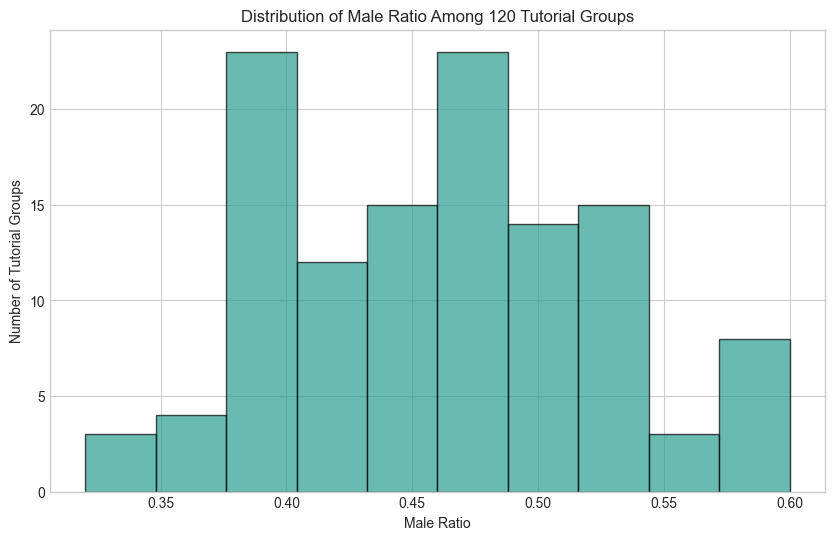

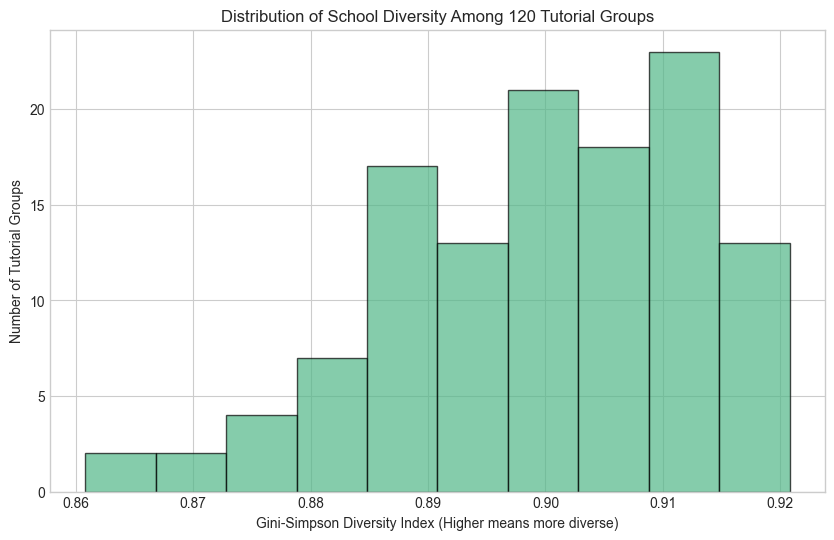

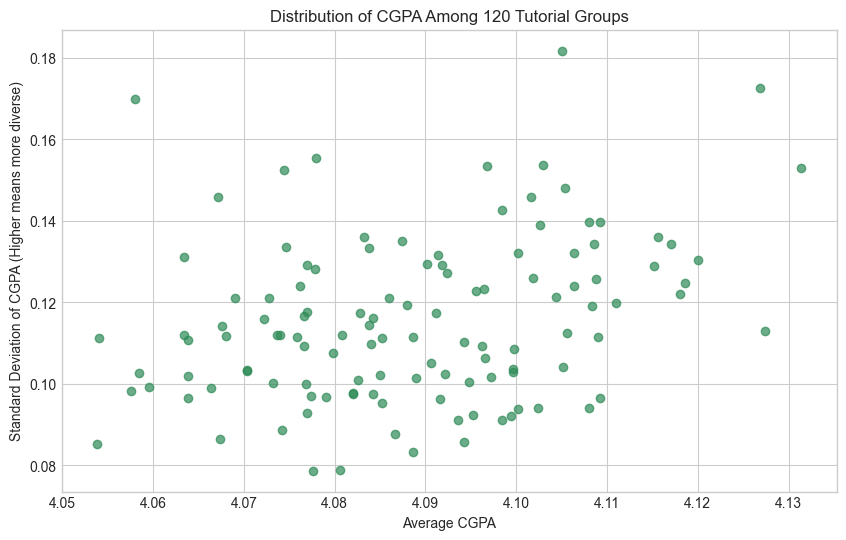

In [35]:
plot_distribution(dataset)

In [9]:
# 熵权法计算权重
# 标准化数据后，根据比例计算熵，根据熵的比例计算权重

def entropy_weight(data_matrix:list)->list:
    n = len(data_matrix) # 学生数量
    m = len(data_matrix[0]) # 指标数量
    norm = []
    for j in range(m):
        col = [data_matrix[i][j] for i in range(n)]
        min_val, max_val = min(col), max(col)
        norm_col = [(x - min_val) / (max_val - min_val + 1e-9) for x in col] 
        norm.append(norm_col) # 熵权法标准化
    norm_T = list(zip(*norm)) # 转置为每行单位为学生存放数据

    P = []  # 比例矩阵 P
    for j in range(m):
        col = [norm_T[i][j] for i in range(n)]
        col_sum = sum(col) + 1e-9 
        P.append([x / col_sum for x in col])

    E = [] # 熵 E
    for j in range(m):
        e = -sum([p * math.log(p + 1e-9) for p in P[j]]) / math.log(n)
        E.append(e)

    D = [1 - e for e in E] # 冗余度 D & 权重 W
    W = [d / sum(D) for d in D]
    return W

# 文字指标转换为数字计算权重
def encode_category(value:int, mapping_dict:dict)->int:
    if value not in mapping_dict:
        mapping_dict[value] = len(mapping_dict) + 1#编码
    return mapping_dict[value]

# 计算权重
def calc_weights(dataset:dict):
    school_map, gender_map = {}, {}
    for group_id, tg in dataset.items():
        data_matrix = []
        for student in tg.groupmate:
            school_code = encode_category(student.school, school_map)
            gender_code = encode_category(student.gender, gender_map)
            cgpa_value = student.cgpa
            data_matrix.append([school_code, gender_code, cgpa_value]) # 文字指标转数字
        weights = entropy_weight(data_matrix)
        tg.weights = {"School": weights[0],"Gender": weights[1],"CGPA": weights[2]}

In [10]:
calc_weights(dataset)
print(dataset['G-1'].weights)

{'School': 0.3682010086876191, 'Gender': 0.5105196722607507, 'CGPA': 0.1212793190516302}


贪心算法部分

伪代码: 
# 这块要改一改啊，比如把quanzhong换成weights，还有一些修改的代码没有更新
```  
FUNCTION calc_score_v1(the list of 5 student, which tutorial group are they from):  
    quanzhong = the previous calculated weights
    
    calculate the gender_score:
        iterate through the members of the five_person group and find the current number of males
        calculate the current proportion of males in the five-person group
        iterate through the members of the tutorial group and find the current number of males
        calculate the current proportion of males in the tutorial group
        the gender_score = the absolute value of proportion's differnce

    calculate the school_diversity:
        find the current number of schools of the group
        find the current number of student of the group
        school_diversity = 1-school_number/student_number

    caculate the cgpa_score:
        calculate the average cgpa of the tutorial group
        calculate the average cgpa of the group
        cgpa_score = the absolute value of (average_cgpa_in_group - average_cgpa_in_tutorialgroup)

    caculate the score:
        score = gender_score*the_weight_of_gender_score + school_diversity*the_weight_of_school_diversity + cgpa_score*the_weigh_of_cgpa_score
```

In [11]:
# 算分, 这里我做出了修改，使用Gini Simpson Index来反应院校多样性
def calc_score(given_list, tutorialgroup:TutorialGroup, method="entropy"):
    if not given_list:
        return float('inf')
    
    # 使用熵权法和自定义权重法，两种方法可以对比，来体现熵权法的优越性
    if method == "entropy":
        weights = tutorialgroup.weights
    elif method == "average":
        weights = {'Gender': 0.33, 'School':0.33, 'CGPA':0.33}
    else:
        weights = DEFAULT_WEIGHTS # 可以自定义一个，这里临时写上
    
    cur_male_ratio, cur_schools_ratio, cur_avg_cgpa, cur_cgpa_range, cur_size = calc_ratio(given_list)
    gender_score = abs(cur_male_ratio - tutorialgroup.male_ratio)
    school_score = 1 - len(cur_schools_ratio) / cur_size
    cgpa_score = abs(cur_avg_cgpa - tutorialgroup.avg_cgpa)

    # 乘以权重，得到最终得分
    final_gender_score = gender_score * weights['Gender'] 
    final_school_score = school_score * weights['School']
    final_cgpa_score = cgpa_score * weights['CGPA']
    score = final_gender_score + final_school_score + final_cgpa_score
    return score

In [12]:
gp = dataset["G-1"]
random_student = random.sample(gp.groupmate, 5)
print([st.gender for st in random_student], gp.male_ratio)
print([st.school for st in random_student])
print([st.cgpa for st in random_student], gp.avg_cgpa)
score = calc_score(random_student, gp)
print(score)

['Female', 'Male', 'Female', 'Female', 'Female'] 0.42
['CCDS', 'WKW SCI', 'EEE', 'EEE', 'CoB (NBS)']
[4.03, 4.15, 4.05, 4.18, 4.03] 4.0956
0.18687625245968134


In [13]:
# 建议把number_of_groups 先写死成全局变量 GP_NUM, 日后如需要交互式输入再修改
# 进行稀有度分层
def hierarchical_grouping(gp:list):
    # 创建分层分组字典stratified_groups，格式:{('学院','性别'):[student1,student2,......],......}
    stratified_groups = defaultdict(list)
    for student in gp:
        key = (student.school, student.gender)
        stratified_groups[key].append(student)
    # 每一层按成绩从高到低排序
    for key in stratified_groups:
        stratified_groups[key].sort(key=lambda x: x.cgpa, reverse=True)
    # 开始按稀有度分组
    sorted_layers = sorted(stratified_groups.items(), key=lambda x:len(x[1])) #此处x：(('学院','性别'),[student1,student2,...])；按稀有度排序
    return sorted_layers

def allocate_first_student(tutorialgroup:TutorialGroup, groups:dict[int:Group], sorted_layers, number_of_groups, method="entropy")->int:
    count = 0 # 记录分了几个人
    # 为每个小组分配第一个人
    for layer_key, students in sorted_layers:
        if count >= number_of_groups:
            break
        if students: #该层非空：
            target = min(groups.keys(), key=lambda x: len(groups[x].groupmate)) # 寻找空的组，获取其编号
            target_student = students.pop(0) # 从该层中拿走成绩最好的学生
            # stratified_groups[layer_key].remove(target_student)
            target_student.group_num = target # 该学生的组号就是当前小组
            groups[target].groupmate.append(target_student) # 将该学生加入小组
            count += 1
            # print(f"将层级{layer_key}的学生分到第{target}组")
    # 更新分数
    for i in range(1, number_of_groups+1):
        groups[i].score = calc_score(groups[i].groupmate, tutorialgroup, method)
    return count

def stratified_grouping(tutorialgroup:TutorialGroup, group_size:int, number_of_groups:int, method="entropy"):
    tutorialgroup_students = tutorialgroup.groupmate # 格式：[student1,student2,......,student50]
    groups = {i: Group(i) for i in range(1, number_of_groups+1)} # 储存分组结果的字典

    # 分层并为每组分配第一个同学, 同时记录已经分配的人数
    sorted_layers = hierarchical_grouping(tutorialgroup_students)
    count = allocate_first_student(tutorialgroup, groups, sorted_layers, number_of_groups, method)
    
    for student in tutorialgroup_students:
        # 对于已经分好组的同学，直接跳过
        if student.group_num != -1:
            continue
        best_group = None
        lowest_score_increase = float('inf') # 计算分数增加的最小值 这个数的来源是什么？如果是要一个很大的数可以用
        best_group_score = None
        full = True # 通过布尔值记录是否所有小组已满，因为前面记录小组数量的时候只取整数而没考虑余数，对于不能整除的情况会剩下一些未分配的同学

        for i in range(1, number_of_groups+1):
            cur_group = groups[i]
            if len(cur_group.groupmate) >= group_size:
                continue
            full = False
            #生成临时小组，计算分数增加量
            previous_score = groups[i].score
            
            cur_group.groupmate.append(student)
            current_score = calc_score(cur_group.groupmate, tutorialgroup, method)
            score_increase = current_score - previous_score
            cur_group.groupmate.pop()
            if score_increase < lowest_score_increase:
                lowest_score_increase = score_increase
                best_group = i
                best_group_score = current_score
        if not full:
            student.group_num = best_group
            groups[best_group].score = best_group_score
            groups[best_group].groupmate.append(student)
        count += 1
    
    # 循环结束后，如果恰好分配完，那么full就是False. 反之如果有剩余，那么full就是True
    # 处理剩下未分配的同学
    if full: 
        randomlist = random.sample(range(1, number_of_groups+1), tutorialgroup.size-count)
        for i in range(count, tutorialgroup.size):
            cur_group = groups[randomlist[i-count]]
            student = tutorialgroup_students[i]
            student.group_num = randomlist[i-count]
            cur_group.groupmate.append(student)
            cur_group.score = calc_score(cur_group.groupmate, tutorialgroup, method)
    
    calc_ratio_groups(groups)
    tutorialgroup.groups = groups

In [14]:
dataset = read_csv("records.csv")
calc_weights(dataset)
tg = dataset["G-1"]
stratified_grouping(tg, group_size=4, number_of_groups=12)

for key, group in tg.groups.items():
    print('-'*10 + 'Group' + str(key) + '-'*10)
    print(f"Male ratio: {group.male_ratio}")
    print(f"School ratio: {group.school_ratio}")
    print(f"Average CGPA: {group.avg_cgpa:.2f}")
    print(f'Group score: {group.score:.2f}')
    # print(f'{[(st.gender, st.school) for st in group.groupmate]} {group.score}')

----------Group1----------
Male ratio: 0.25
School ratio: {'WKW SCI': 0.25, 'SoH': 0.25, 'MAE': 0.25, 'SSS': 0.25}
Average CGPA: 4.03
Group score: 0.09
----------Group2----------
Male ratio: 0.5
School ratio: {'WKW SCI': 0.25, 'CCDS': 0.25, 'SSS': 0.25, 'EEE': 0.25}
Average CGPA: 4.10
Group score: 0.04
----------Group3----------
Male ratio: 0.5
School ratio: {'SBS': 0.25, 'EEE': 0.25, 'SSS': 0.25, 'SoH': 0.25}
Average CGPA: 4.11
Group score: 0.04
----------Group4----------
Male ratio: 0.5
School ratio: {'ASE': 0.25, 'CCDS': 0.25, 'CoB (NBS)': 0.25, 'EEE': 0.25}
Average CGPA: 4.15
Group score: 0.05
----------Group5----------
Male ratio: 0.5
School ratio: {'CoE': 0.25, 'CoB (NBS)': 0.25, 'SoH': 0.25, 'EEE': 0.25}
Average CGPA: 4.09
Group score: 0.04
----------Group6----------
Male ratio: 0.5
School ratio: {'NIE': 0.25, 'EEE': 0.25, 'CoB (NBS)': 0.25, 'MAE': 0.25}
Average CGPA: 4.05
Group score: 0.05
----------Group7----------
Male ratio: 0.5
School ratio: {'ADM': 0.25, 'CoB (NBS)': 0.25,

In [47]:
# 画小组男性比例
def plot_group_male_ratio(axis, group_labels, male_ratios, gp_male_ratio):
    axis.bar(group_labels, male_ratios, color='#a8dadc')
    axis.axhline(y=gp_male_ratio, color='#2a9d8f', linestyle='--', label=f'Group Male Ratio = {gp_male_ratio}')
    axis.set_title('Male Ratio')
    axis.set_ylim(0, 1)
    axis.set_ylabel('Male Ratio')
    axis.legend()
    axis.grid(True)  

# 画小组院校数量
def plot_group_school_ratio(axis, group_labels, school_ratios):
    unique_school_counts = [len(school_ratio) for school_ratio in school_ratios]
    axis.bar(group_labels, unique_school_counts, color='seagreen')
    axis.set_title('School Diversity')
    axis.set_ylim(max(0, min(unique_school_counts)-2), max(unique_school_counts)+1)
    axis.set_ylabel('Number of Unique Schools')
    axis.grid(True)

# 画小组平均CGPA
def plot_group_cgpa(axis, group_labels, avg_cgpas, gp_avg_cgpa):
    axis.bar(group_labels, avg_cgpas, color='#90be6d')
    axis.axhline(y=gp_avg_cgpa, color='#2a9d8f', linestyle='--', label=f'Group Average CGPA = {gp_avg_cgpa:.2f}')
    axis.set_title('Average CGPA')
    axis.set_ylim(min(avg_cgpas) * 0.95, max(avg_cgpas) * 1.05)
    axis.set_ylabel('Average CGPA')
    axis.legend()
    axis.grid(True)

# 将上述三幅图画到一起
def plot_group_distribution(tutorialgroup:TutorialGroup, title="Greedy Algorithm Result"):
    groups = tutorialgroup.groups
    tutorialgroup_id = tutorialgroup.group_id
    group_labels = [str(i) for i in groups.keys()]

    figsize_width = max(15, len(groups)*1.2) 
    fig, axes = plt.subplots(1, 3, figsize=(figsize_width, 6))
    fig.suptitle(f'{title} for {tutorialgroup_id}', fontsize=20)

    male_ratios = [group.male_ratio for group in groups.values()]
    school_ratios = [group.school_ratio for group in groups.values()]
    avg_cgpas = [group.avg_cgpa for group in groups.values()]
    gp_male_ratio = tutorialgroup.male_ratio
    gp_avg_cgpa = tutorialgroup.avg_cgpa

    plot_group_male_ratio(axes[0], group_labels, male_ratios, gp_male_ratio)
    plot_group_school_ratio(axes[1], group_labels, school_ratios)
    plot_group_cgpa(axes[2], group_labels, avg_cgpas, gp_avg_cgpa)

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])

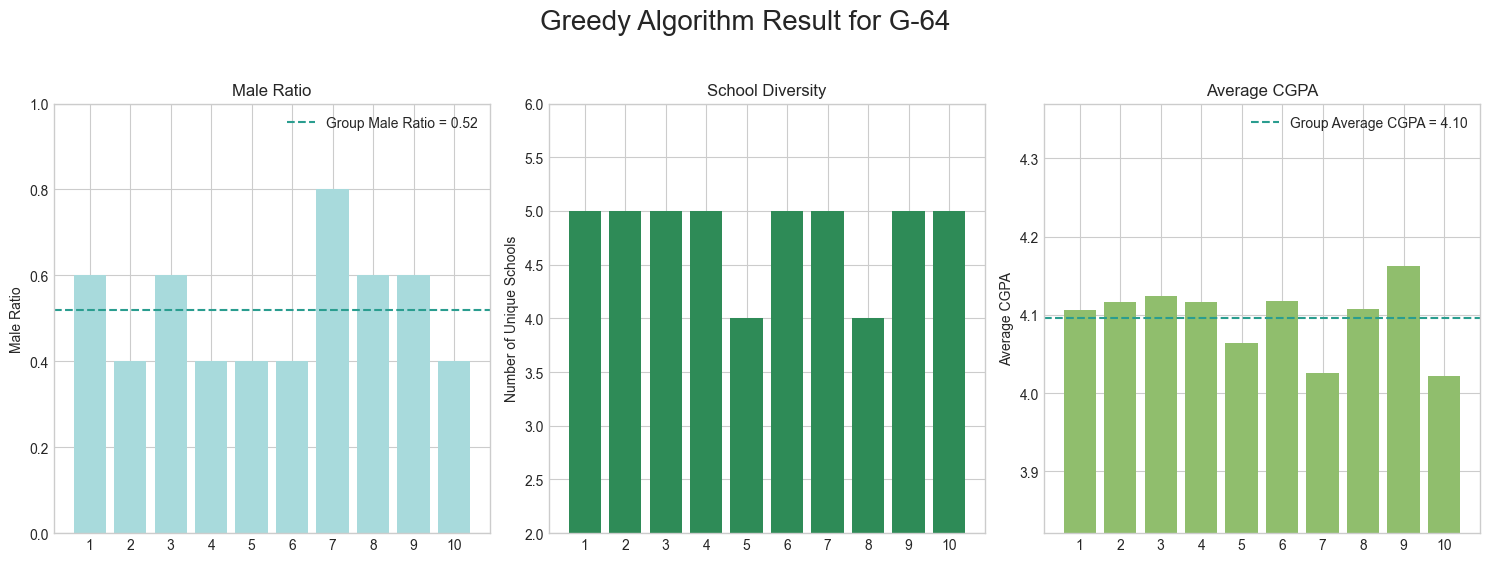

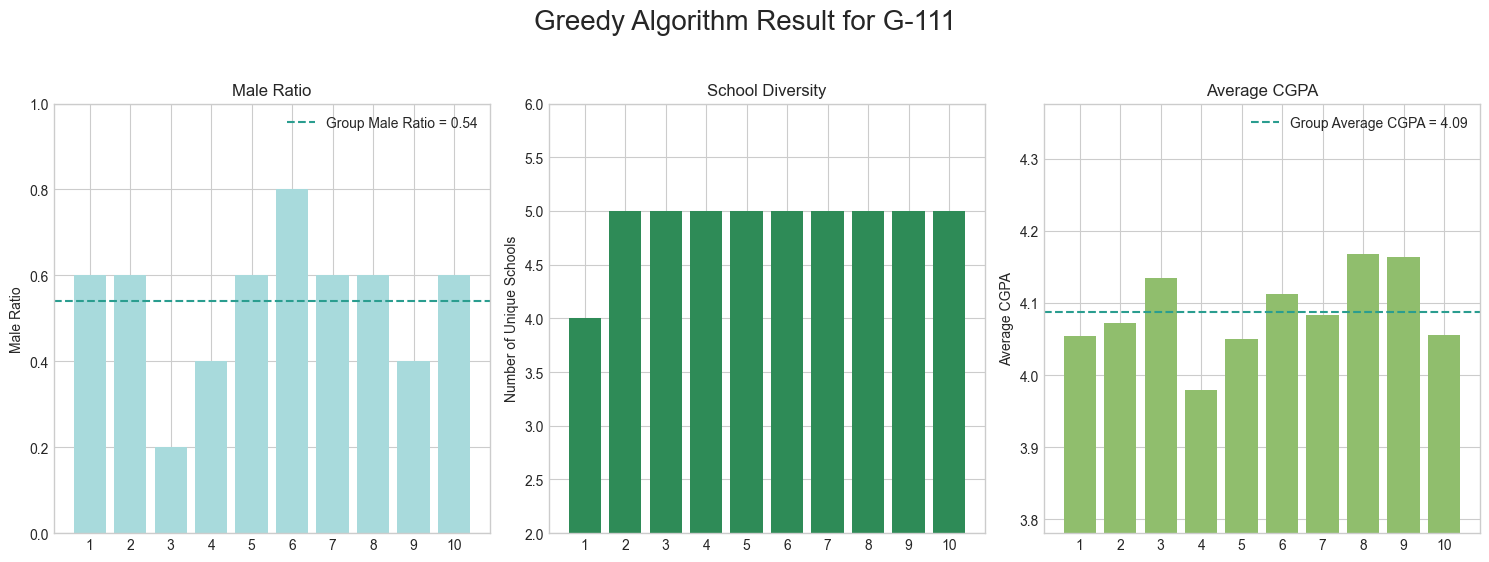

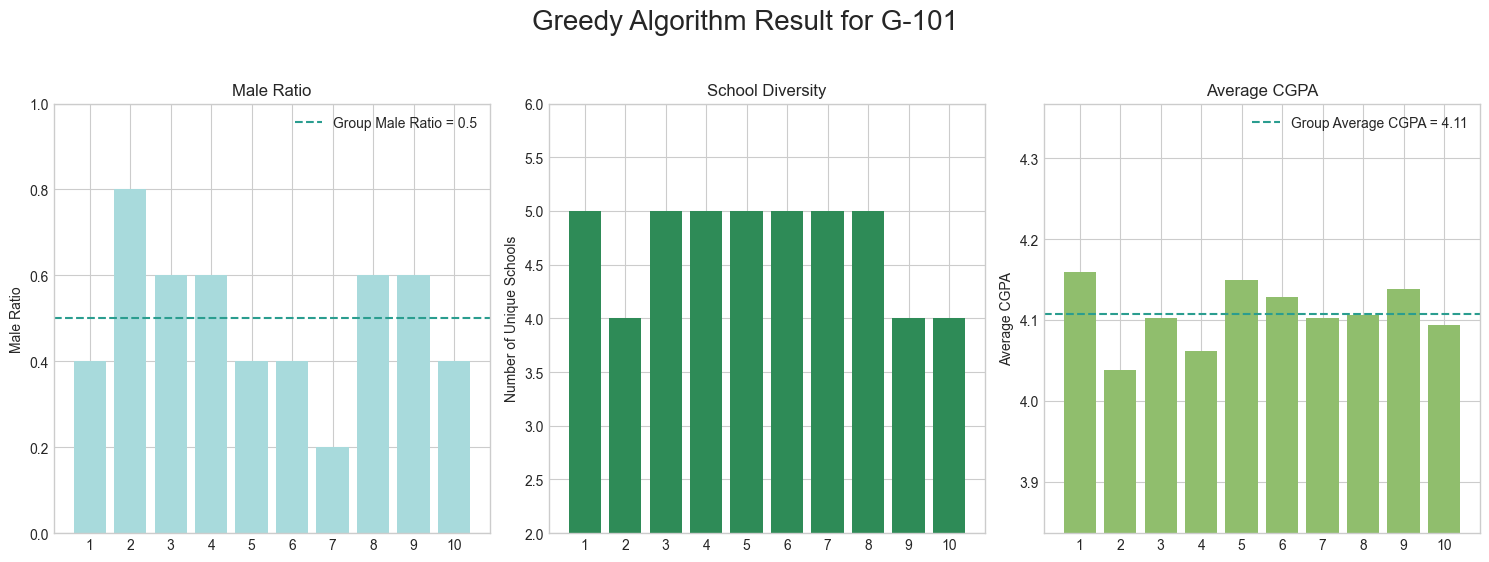

In [51]:
# 测试：随机选出3组并画出初次分组后的结果
random.seed(RANDOM_SEED)
dataset = read_csv("records.csv")
calc_weights(dataset)
tg_list = [t for t in dataset.values()]
random_tg = random.sample(tg_list, 3)
for tg in random_tg:
    stratified_grouping(tg, group_size=5, number_of_groups=10)
    plot_group_distribution(tg)

交换退火

交换函数

伪代码：  
FUNCTION exchange_two(groups):  
    ID1,ID2 = randomly choose 2 groups from group  
    pick1 = selected group1  
    pick2 = selected group2  
    student1,student2 = randomly choose 1 student from each selected group  
    exchange student1 and student2  
    RETURN pick1,pick2,student1,student2

In [17]:
def select_two(cur_groups:dict[int:Group]):
    # 随机选取两个组
    groups = [gp for gp in cur_groups.values()]
    group1, group2 = random.sample(groups, 2)  
    # 每组分别随机选取一个学生
    student_idx1 = random.randint(0, len(group1.groupmate)-1)
    student_idx2 = random.randint(0, len(group2.groupmate)-1) 
    return group1, group2, student_idx1, student_idx2

def exchange_two(group1:Group, group2:Group, student_idx1:int, student_idx2:int):
    group1.groupmate[student_idx1],group2.groupmate[student_idx2] = group2.groupmate[student_idx2],group1.groupmate[student_idx1] # 交换两个人

计算交换后的分数

判断是否接受

伪代码:
FUNCTION accept_change(delta,temperature):  
    IF delta > 0:
        RETURN True
    ELSE:
        sta = exp(delta/temperature)
        IF:
            random_value < sta
                RETURN TRUE
        ElSE:
            RETURN False            

In [18]:
def accept_change(delta,temperature):  #delta和temperature在后面退火的函数再说，delta就是分数差
    if delta > 0:
        return True   #交换后变好，直接接受
    else:
        sta = math.exp(delta/temperature)
        return random.random() < sta   #变坏后有一定几率接受

退火主函数

伪代码：  
```
FUNCTION annealing(groups,tutorialgroup_id,initial_temp=100 (#initial temperature),cooling_rate=0.99 (#the speed of cooling),min_tem (#min temperature,when temperature<min_temperature,break),max_iter=1000 (#it can iterate at most 1000 times)):  
    current_groups = copy_of_groups
    current_score = the_group_score_obtained_from_the_previous_process  
    initialize temperature = 0  
    initialize iteration = 0  
    initialize the num of consecutive exchanges that are all not accepted = 0  
    WHILE temperature is not below min_tem AND iteration has not exceeded max_iter:  
        iteration = iteration+1  
        initialize new_groups = current_groups  
        initialize new_score = current_score  
        use exchange_two to exchange two student  
        calculate new_score of the tutorial group  
        caculate the score difference before and after  
        IF change is accepted:  
            current_groups = new_groups  
            currrent_score = new_score  
            let no_change_count = 0 again
        ELSE:  
            no_change_count = no_change_count +1   
    temperature cool down  
    RETURN current_groups,current_score    
```  

In [19]:
# 模拟退火
def annealing(tutorialgroup:TutorialGroup, number_of_groups, initial_temp=100, cooling_rate=0.98, min_temp=0.01, max_iter=1000, max_no_change=50, method="entropy"):  #这些都是自己定义的数据，后面商量一下定位多少
    temperature = initial_temp
    iteration = 0  # 计算迭代次数
    no_change_count = 0  # 计算连续交换后都不接受的情况发生的次数
    
    while temperature > min_temp and iteration < max_iter and no_change_count < max_no_change:
        iteration += 1
        group1, group2, student_idx1, student_idx2 = select_two(tutorialgroup.groups)
        
        # 记录交换前的分数
        previous_score_1 = group1.score
        previous_score_2 = group2.score
        previous_score = previous_score_1 + previous_score_2
        # 交换
        exchange_two(group1, group2, student_idx1, student_idx2) # 交换
        # 记录交换后的分数
        cur_score_1 = calc_score(group1.groupmate, tutorialgroup, method)
        cur_score_2 = calc_score(group2.groupmate, tutorialgroup, method)
        new_score = cur_score_1 + cur_score_2
        delta = previous_score - new_score  # 计算调换后的分数与原来分数之差
        if accept_change(delta, temperature):
            no_change_count = 0 # 因为是连续不接受，所以一旦接受就重新变成0
            # 更新交换后小组的分数
            group1.score, group2.score = cur_score_1, cur_score_2
        else:
            no_change_count += 1
            # 交换失败，再把他们换回来
            exchange_two(group1, group2, student_idx1, student_idx2)
        temperature *= cooling_rate  # 每次循环后降温一次
    calc_ratio_groups(tutorialgroup.groups)

In [20]:
# 输入每组人数
def ask_for_input(use_defalut_value=True):
    if use_defalut_value: # 后续如果需要，输入一个False即可
        return 5, 10
    valid_input = False
    group_size = 0
    while not (4 <= group_size <= 10) or not valid_input:
        try:
            print("Please enter the Group size: ")
            group_size = int(input())
            valid_input = True
            if not (4 <= group_size <= 10):
                print("Invalid Input. Please enter a integer between 4 and 10.")
        except:
            print("Invalid Input. Please enter a integer between 4 and 10.")
    number_of_groups = GP_SIZE // group_size
    return group_size, number_of_groups

In [21]:
# 将分组结果导出为csv
def write_csv(dataset, path):
    with open(path,"w",newline = '',encoding="utf-8") as f:
        writer = csv.writer(f)
        header = ['Tutorial Group', 'Group', 'Student ID', 'School', 'Name', 'Gender', 'CGPA']
        writer.writerow(header)
        for tutorialgroup_id, tutorialgroup in dataset.items():
            for student in tutorialgroup.groupmate:
                row = [tutorialgroup_id, student.group_num, student.student_id, student.school, student.name, student.gender, student.cgpa]
                writer.writerow(row)

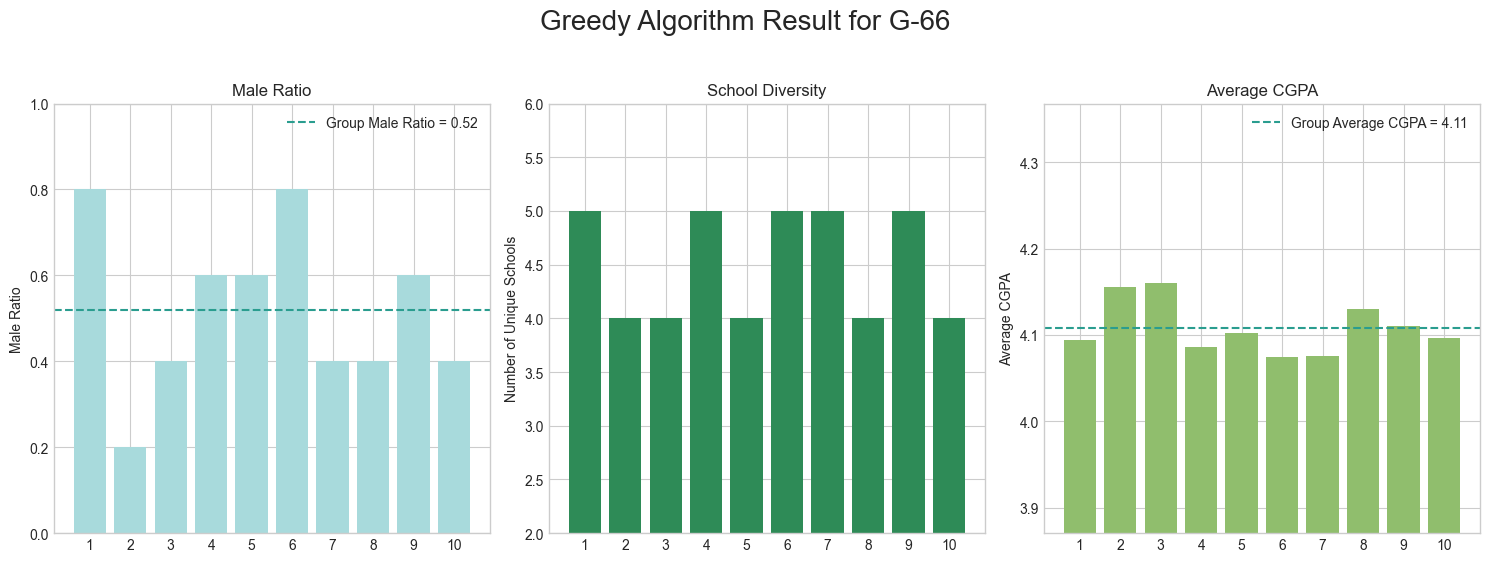

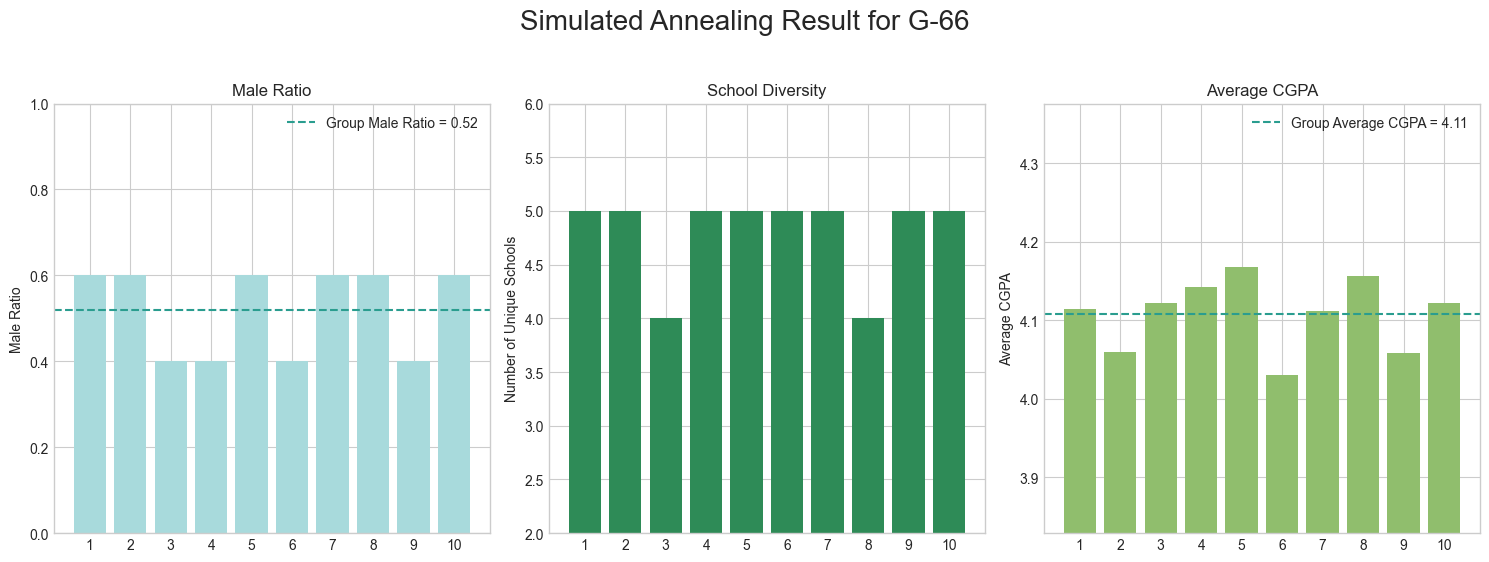

In [56]:
# 测试：指定一个小组，看看它经过两次算法后分组情况如何
random.seed(RANDOM_SEED)
dataset = read_csv("records.csv")
calc_weights(dataset)
tg = dataset["G-66"]
stratified_grouping(tg, group_size=5, number_of_groups=10,method="entropy")
plot_group_distribution(tg)
annealing(
    tutorialgroup = tg, 
    number_of_groups = 10, 
    method = "entropy"
    )
plot_group_distribution(tg, title="Simulated Annealing Result")

In [23]:
# 统计各组合格的分配小组的数量
def calc_qualified_num(dataset, number_of_groups):
    gender_list = []
    school_list = []
    cgpa_list = []
    tg_num = len(dataset)
    row_num = 10
    col_num = tg_num // row_num

    for gp_id, tutorialgroup in dataset.items():
        gp_male_ratio = tutorialgroup.male_ratio
        gp_avg_cgpa = tutorialgroup.avg_cgpa
        qualified_gender = 0
        qualified_school = 0
        qualified_cgpa = 0  
        for group in tutorialgroup.groups.values():
            # 性别比例：每组不能太极端，认为男性人数为小组平均+-1人之内的为合格
            # 院校分布：认定大于(每组人数-1)为合格
            # CGPA分布：每组不能太极端，认为在平均值*(0.975~1.025)之内的为合格

            gp_size = group.size
            if gp_male_ratio - 1/gp_size <= group.male_ratio <= gp_male_ratio + 1/gp_size:
                qualified_gender += 1
            if len(group.school_ratio) >= gp_size - 1:
                qualified_school += 1
            if gp_avg_cgpa * 0.975 <= group.avg_cgpa <= gp_avg_cgpa * 1.025:
                qualified_cgpa += 1
        gender_list.append(qualified_gender / number_of_groups)            
        school_list.append(qualified_school / number_of_groups)            
        cgpa_list.append(qualified_cgpa / number_of_groups) 
    gender_matrix = [gender_list[col_num*i:col_num*i+row_num] for i in range(row_num)]
    school_matrix = [school_list[col_num*i:col_num*i+row_num] for i in range(row_num)]
    cgpa_matrix = [cgpa_list[col_num*i:col_num*i+row_num] for i in range(row_num)]
    return gender_matrix, school_matrix, cgpa_matrix

def plot_single_heatmap(axis, matrix, title):
    sns.heatmap(matrix, ax=axis, cmap="YlGn", annot=True, fmt=".1f", vmin=0, vmax=1)
    axis.set_title(title, fontsize=16)
    axis.set_xticks([]) 
    axis.set_yticks([])

def plot_all_heatmap(gender_matrix, school_matrix, cgpa_matrix, main_title):
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle(f'Ratio of Qualified Groups ({main_title})', fontsize=20)
    plot_single_heatmap(axes[0], gender_matrix, "Gender")
    plot_single_heatmap(axes[1], school_matrix, "School")
    plot_single_heatmap(axes[2], cgpa_matrix, "CGPA")
    plt.tight_layout(rect=[0, 0.05, 0.95, 0.95])

def judge_the_result(dataset, number_of_groups,main_title):
    gender_matrix, school_matrix, cgpa_matrix = calc_qualified_num(dataset, number_of_groups)
    plot_all_heatmap(gender_matrix, school_matrix, cgpa_matrix, main_title)

In [24]:
# 设计一个随机分组的算法，用来对比，不用管具体的实现方法
def random_grouping(random_seed, group_size, number_of_groups,show_plot=False):
    random.seed(random_seed)
    dataset = read_csv("records.csv")
    for tutorialgroup in dataset.values():
        count = 0
        for i in range(number_of_groups):
            rest_student = [st for st in tutorialgroup.groupmate if st.group_num != -1]
            random_list = random.sample(tutorialgroup.groupmate, group_size)
            for student in random_list:
                student.group_num = i+1
            group = Group(i+1)
            group.groupmate = [st for st in random_list]
            count += group_size
            tutorialgroup.groups[i+1] = group
        if count < tutorialgroup.size:
            randomlist = random.sample(range(1, number_of_groups+1), tutorialgroup.size-count)
            rest_student = [st for st in tutorialgroup.groupmate if st.group_num != -1]
            for i in range(count, tutorialgroup.size):
                cur_group = tutorialgroup.groups[randomlist[i-count]]
                student = rest_student[i-count]
                student.group_num = randomlist[i-count]
                cur_group.groupmate.append(student)
        calc_ratio_groups(tutorialgroup.groups)
    if show_plot:
        judge_the_result(dataset, number_of_groups, "Random Grouping")

主程序

In [25]:
def main(random_seed=RANDOM_SEED, cooling_rate=0.98,method="entropy",show_plot=(False, False), output=True):
    random.seed(random_seed) # 设置随机种子，确保结果可复现
    group_size, number_of_groups = ask_for_input(use_defalut_value=True) # 保持为True就是分10组5人，改为False就可以输入自定义的数值
    dataset = read_csv("records.csv")
    calc_weights(dataset)

    for gp_id, tutorialgroup in dataset.items():
        stratified_grouping(
            tutorialgroup = tutorialgroup, 
            group_size = group_size, 
            number_of_groups = number_of_groups, 
            method = method
            )
    if show_plot[0]:
        judge_the_result(dataset, number_of_groups, f"Greedy Algorithm + {method} weights")
    
    for gp_id, tutorialgroup in dataset.items():
        annealing(
            tutorialgroup = tutorialgroup, 
            number_of_groups = number_of_groups, 
            cooling_rate = cooling_rate,
            method = method
            )
    if show_plot[1]:
        judge_the_result(dataset, number_of_groups, f"Simulated Annealing + {method} weights")
        
    if output:
        write_csv(dataset, path="output.csv")
    print("Finished!")

### 以下的大部分为数据分析，请加入文字说明

Finished!


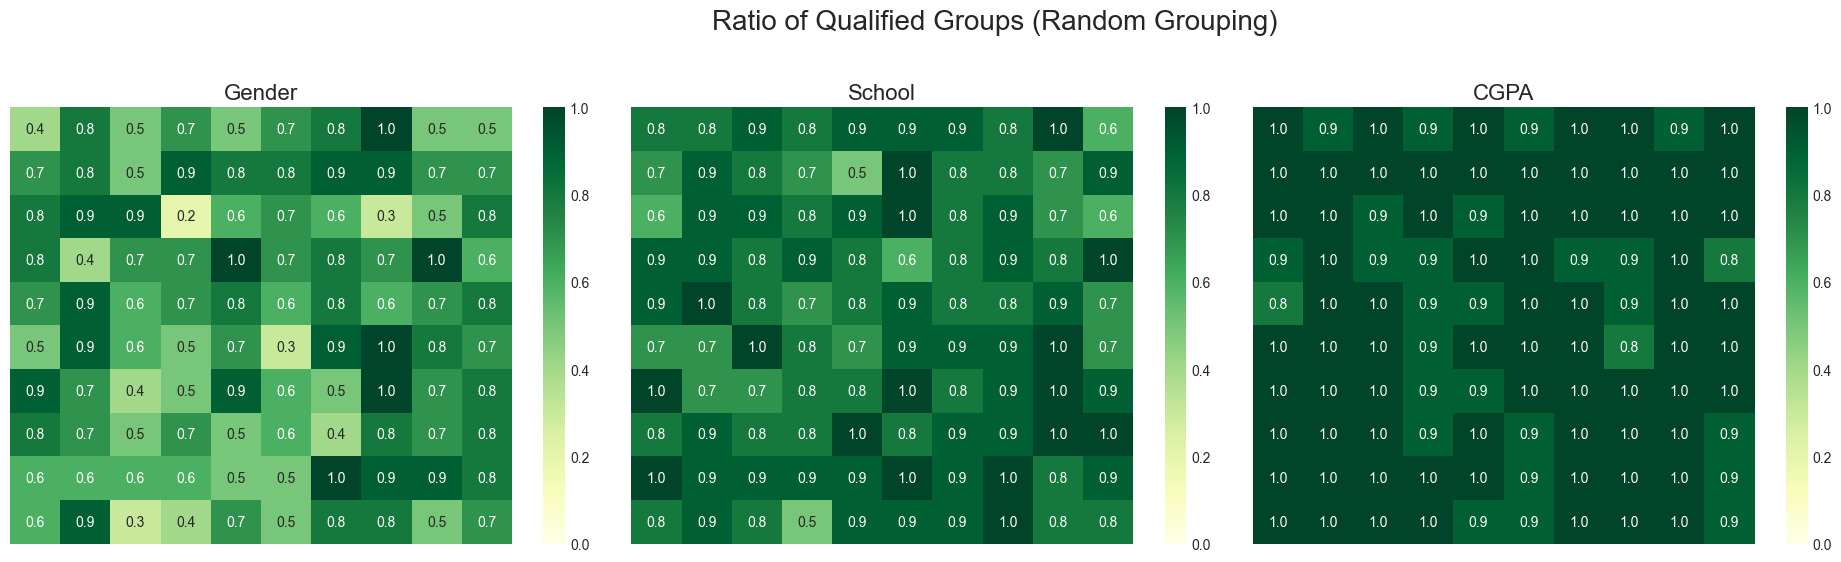

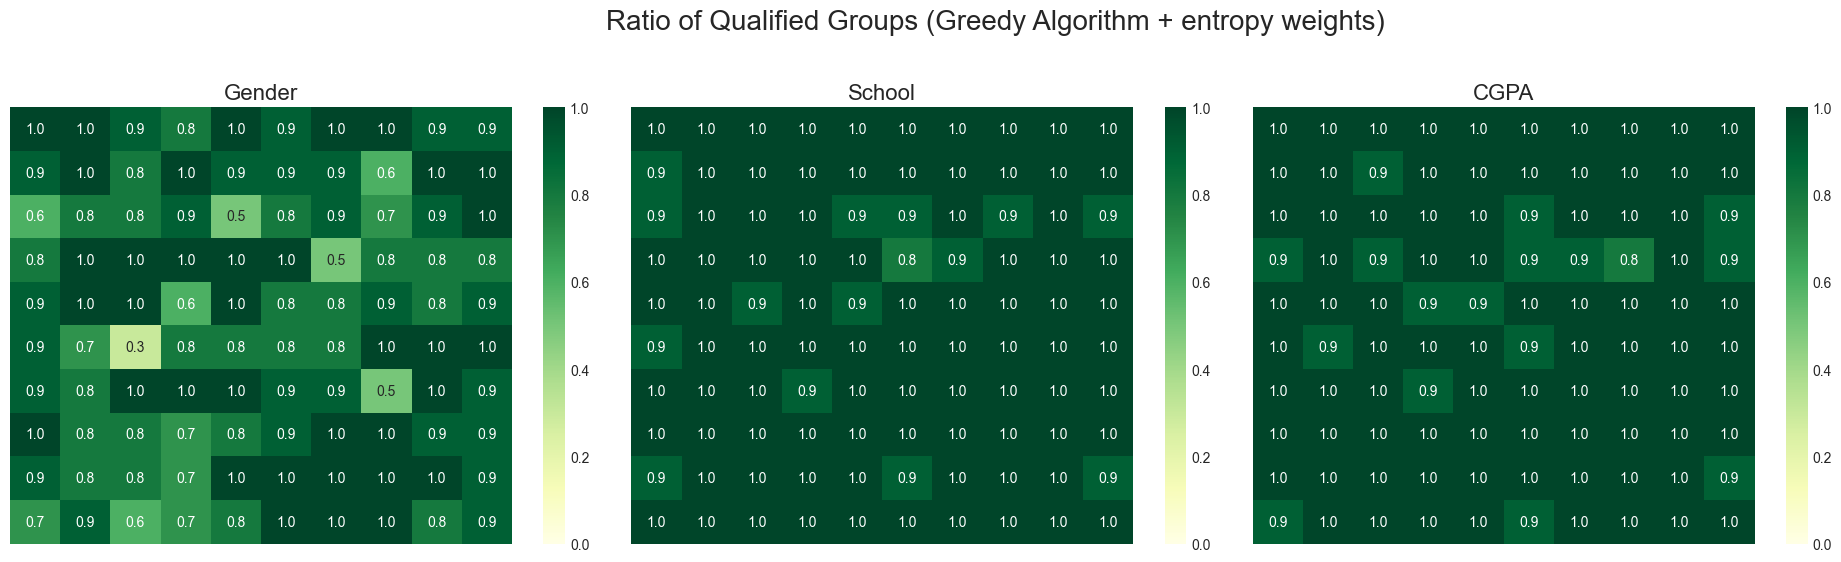

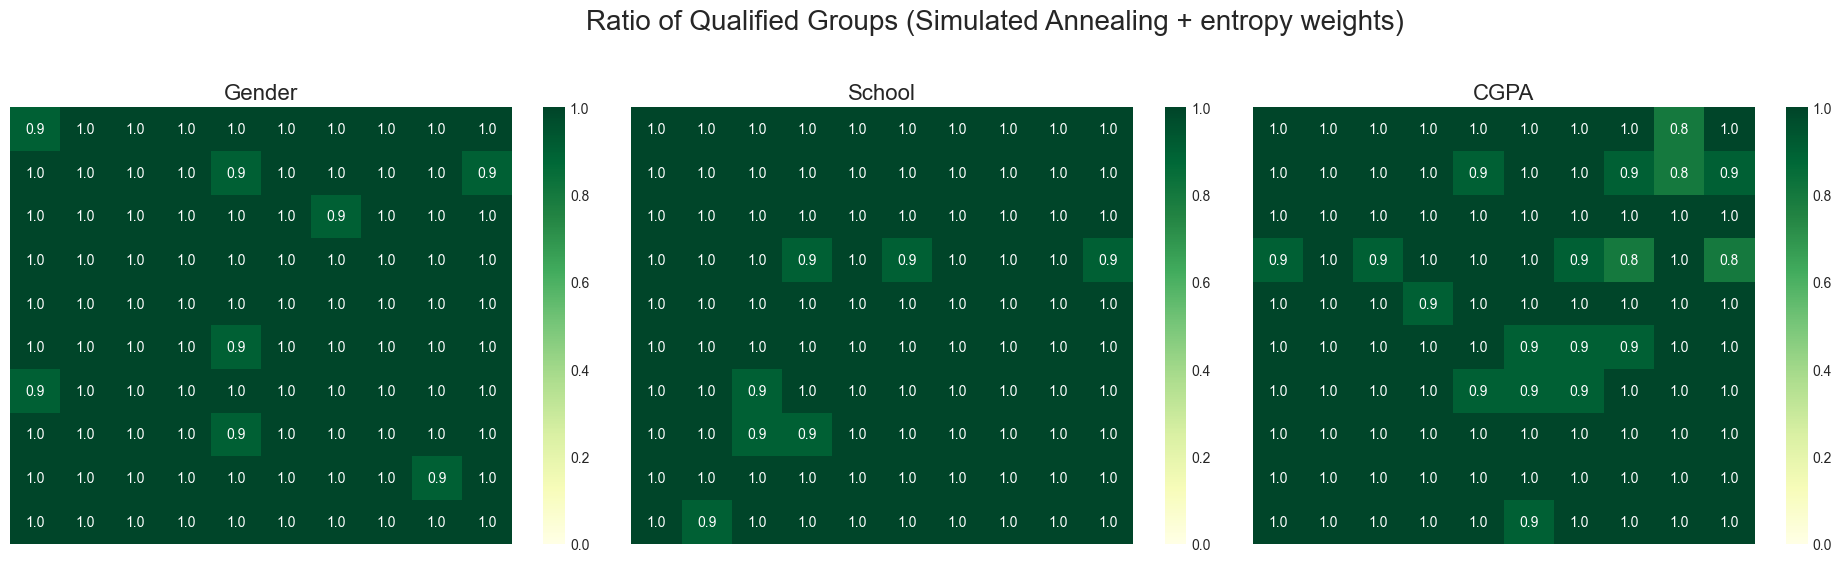

In [26]:
# 对比三种算法
random_grouping(42, 5, 10, show_plot=True)
main(show_plot=(True,True), output=False)

Finished!
Finished!
Finished!


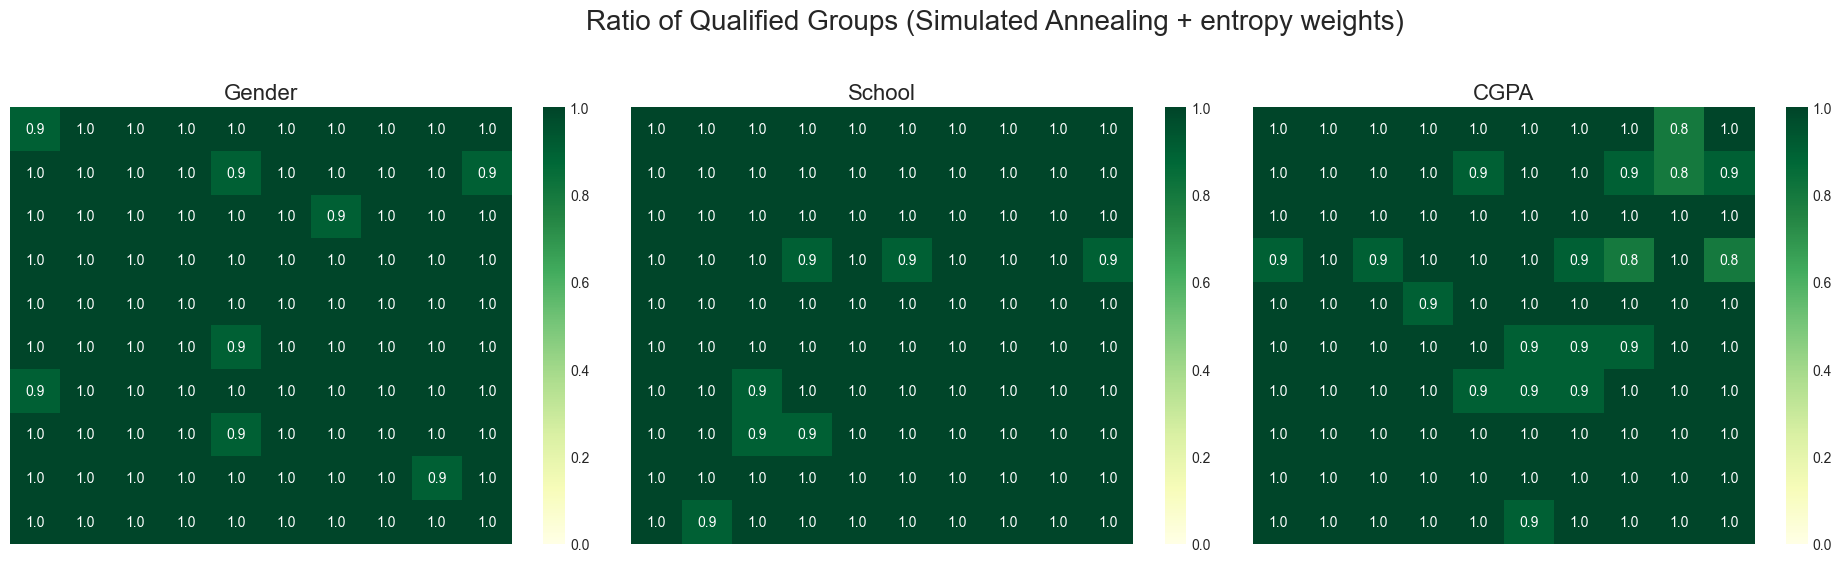

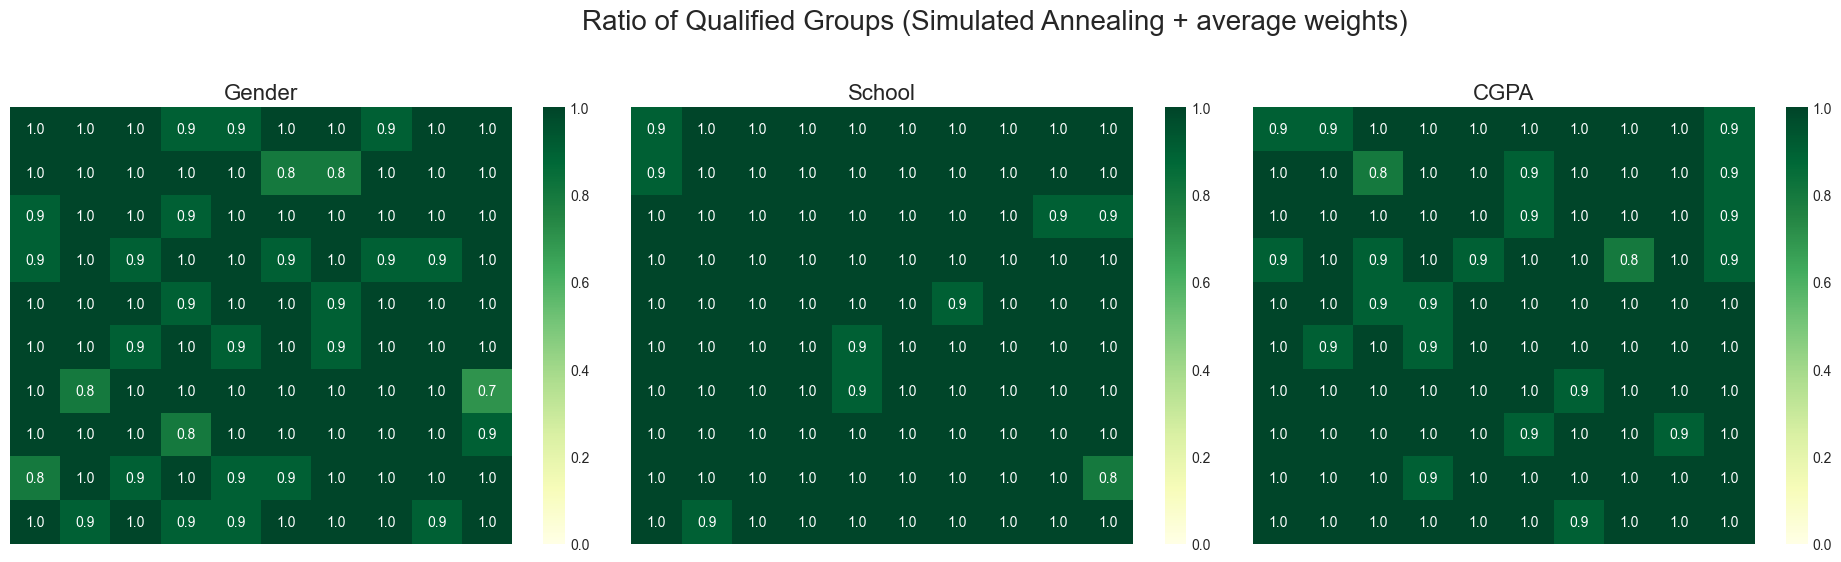

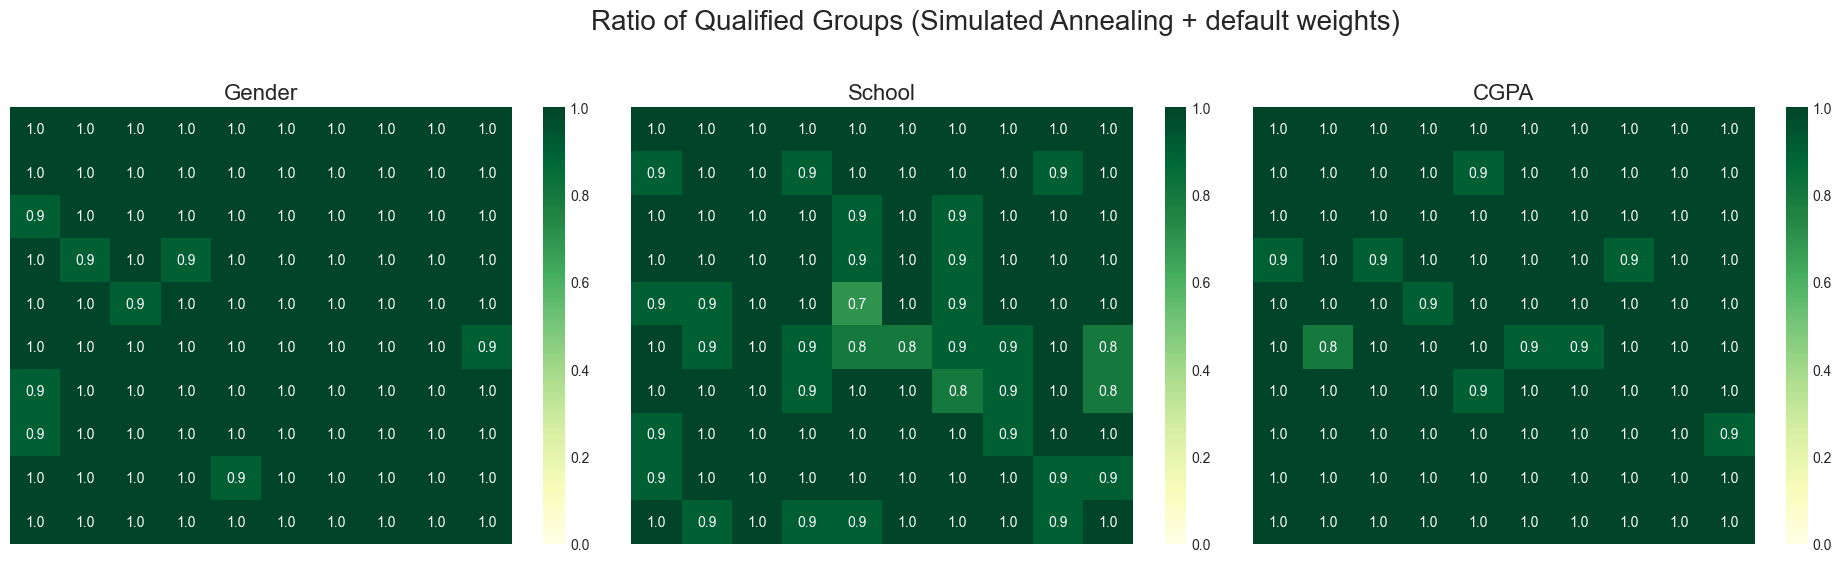

In [27]:
# 对比三种权重
main(method="entropy",show_plot=(False,True), output=False)
main(method="average",show_plot=(False,True), output=False)
main(method="default",show_plot=(False,True), output=False)

In [28]:
# 构建交互面板，探究最好的降温率
# 提前计算好数据，防止交互时临时计算浪费时间
def pre_calc(group_size, number_of_groups,method="entropy"):
    cooling_rates =  [i / 1000.0 for i in range(850, 995 + 1, 5)]
    results = {}
    dataset = read_csv("records.csv")
    calc_weights(dataset) 
    
    for gp_id, tutorialgroup in dataset.items():
        stratified_grouping(
            tutorialgroup = tutorialgroup, 
            group_size = group_size, 
            number_of_groups = number_of_groups, 
            method = method
            )
        
    # 由于关注点在退火上，因此以贪心算法结束后的dataset为节点，开始针对不同的降温率进行模拟退火计算
    for rate in cooling_rates:
        temp = {key:value for key,value in dataset.items()}
        for gp_id, tutorialgroup in temp.items():
            annealing(
                tutorialgroup = tutorialgroup, 
                number_of_groups = number_of_groups, 
                cooling_rate = rate,
                method = method
                )
            
            gender_matrix, school_matrix, cgpa_matrix = calc_qualified_num(dataset, number_of_groups)
            results[rate] = (gender_matrix, school_matrix, cgpa_matrix)
        print(f"Precalculated distribution while cooling rate = {rate}")
    return results

def interaction_in_notebook(results):
    
    def plot_interaction(cooling_rate, results_cache):
        clear_output(wait=True)
        plt.close('all')
        cooling_rate = round(cooling_rate, 3)
        gender_matrix, school_matrix, cgpa_matrix = results[cooling_rate]
        plot_all_heatmap(gender_matrix, school_matrix, cgpa_matrix, main_title=f"Cooling rate = {cooling_rate}")
    
    interaction = widgets.interactive(
        plot_interaction, 
        cooling_rate = widgets.FloatSlider(min=0.90, max=0.995, step=0.005, value=0.980, description='Cooling Rate',readout_format='.3f'),
        results_cache = widgets.fixed(results)
    )
    
    display(interaction)

In [29]:
results = pre_calc(5, 10)

Precalculated distribution while cooling rate = 0.85
Precalculated distribution while cooling rate = 0.855
Precalculated distribution while cooling rate = 0.86
Precalculated distribution while cooling rate = 0.865
Precalculated distribution while cooling rate = 0.87
Precalculated distribution while cooling rate = 0.875
Precalculated distribution while cooling rate = 0.88
Precalculated distribution while cooling rate = 0.885
Precalculated distribution while cooling rate = 0.89
Precalculated distribution while cooling rate = 0.895
Precalculated distribution while cooling rate = 0.9
Precalculated distribution while cooling rate = 0.905
Precalculated distribution while cooling rate = 0.91
Precalculated distribution while cooling rate = 0.915
Precalculated distribution while cooling rate = 0.92
Precalculated distribution while cooling rate = 0.925
Precalculated distribution while cooling rate = 0.93
Precalculated distribution while cooling rate = 0.935
Precalculated distribution while cooli

In [30]:
interaction_in_notebook(results)

interactive(children=(FloatSlider(value=0.98, description='Cooling Rate', max=0.995, min=0.9, readout_format='…

很显然在cooling_rate=0.99时整体结果最好。高于0.99，效果会急转直下（因为有最大降温步数的限制，高降温率导致降温不充分）；低于0.99，效果会越来越差

In [57]:
# 对比之后，最后的选择：贪心+退火，熵权法，降温率0.99. 这段代码会导出最后的数据
# 不知何故，我这里如果想让上面的交互面板正常运行，下面的程序就不能执行。
# 如果想看输出，请取消下面代码的注释

main(cooling_rate=0.99)

Finished!
